**Suppress Warnings**

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

Dataset Link: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip

**Import Necessary Libraries and Set Dataset Paths**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Set dataset paths
train_dir = "C:/Users/shakib/Downloads/fruits-360-original-size/Training"
val_dir = "C:/Users/shakib/Downloads/fruits-360-original-size/Validation"
test_dir = "C:/Users/shakib/Downloads/fruits-360-original-size/Test"

**Setup Data Generators for Training, Validation, and Testing with Augmentation**

In [3]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


**Define VGG16-Based Model Architecture with Custom Layers**

In [4]:
# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

**Compile Model with Appropriate Loss and Optimizer**

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Train Model with Early Stopping and Learning Rate Scheduling**

In [6]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
# set_global_policy('mixed_float16')

steps_per_epoch = len(train_generator) // train_generator.batch_size
validation_steps = len(val_generator) // val_generator.batch_size

history = model.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/6
24/24 [==============================] - 28s 1s/step - loss: 3.9420 - accuracy: 0.0755 - val_loss: 6.4738 - val_accuracy: 0.0260 - lr: 0.0010
Epoch 2/6
24/24 [==============================] - 26s 1s/step - loss: 3.2688 - accuracy: 0.1276 - val_loss: 3.7937 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/6
24/24 [==============================] - 26s 1s/step - loss: 2.8220 - accuracy: 0.2266 - val_loss: 3.4992 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 4/6
24/24 [==============================] - 26s 1s/step - loss: 2.7286 - accuracy: 0.2109 - val_loss: 3.0772 - val_accuracy: 0.2448 - lr: 0.0010
Epoch 5/6
24/24 [==============================] - 26s 1s/step - loss: 2.4313 - accuracy: 0.2812 - val_loss: 2.2096 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 6/6
24/24 [==============================] - 26s 1s/step - loss: 2.3285 - accuracy: 0.3151 - val_loss: 1.6144 - val_accuracy: 0.5104 - lr: 0.0010


**Fine-Tune Model by Unfreezing Specific Layers in VGG16**

In [7]:
# Unfreeze the last 2 layers for fine-tuning
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    steps_per_epoch=120,  # Reduced steps per epoch
    validation_steps=30,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/2
120/120 [==============================] - 115s 946ms/step - loss: 2.0476 - accuracy: 0.3794 - val_loss: 1.1317 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 2/2
120/120 [==============================] - 112s 931ms/step - loss: 1.6763 - accuracy: 0.4835 - val_loss: 0.7434 - val_accuracy: 0.8479 - lr: 1.0000e-04


**Evaluate Model on Test Set and Display Accuracy**

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

195/195 [==============================] - 135s 693ms/step - loss: 0.7293 - accuracy: 0.8476
Test Accuracy: 0.85


**Visualize Training Performance with Accuracy and Loss Curves**

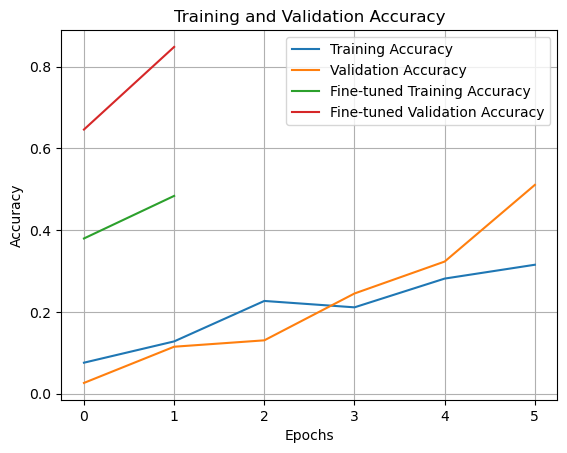

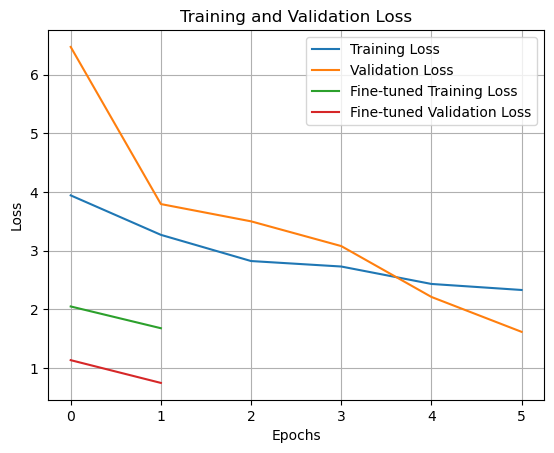

In [9]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

**Test Model Predictions on Sample Images and Visualize Results**

1/1 [==============================] - 0s 291ms/step


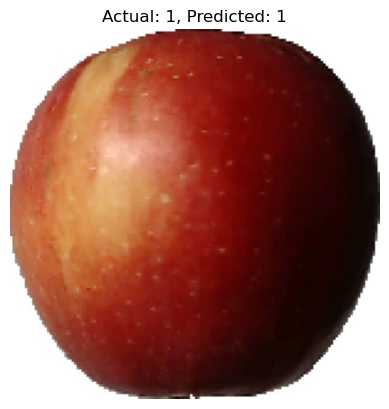

1/1 [==============================] - 0s 100ms/step


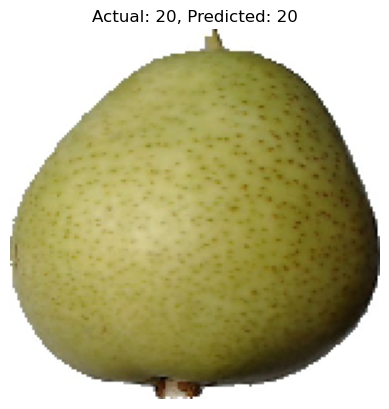

1/1 [==============================] - 0s 110ms/step


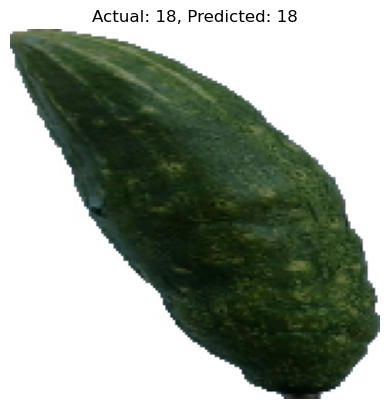

In [10]:
# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

def visualize_prediction_with_actual(img_path, true_label):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Update the counters
    actual_count[true_label] += 1
    predicted_count[predicted_class] += 1

    # Visualize the image with predictions
    plt.imshow(img)
    plt.title(f"Actual: {true_label}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Test on a few images
sample_images = [
    ('C:/Users/shakib/Downloads/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg', '1'),
    ('C:/Users/shakib/Downloads/fruits-360-original-size/Test/pear_1/r0_103.jpg', '20'),
    ('C:/Users/shakib/Downloads/fruits-360-original-size/Test/cucumber_3/r0_103.jpg', '18'),
]

# Run the predictions and visualization
for img_path, true_label in sample_images:
    visualize_prediction_with_actual(img_path, true_label)